#### By: Peyman Shahidi
#### Created: Nov 10, 2025
#### Last Edit: Nov 11, 2025

<br>

In [34]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [35]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects/aiChain_length_count'
output_plot_path = f"{main_folder_path}/writeup/plots/aiChain_length_count"

In [36]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [37]:
# Read the merged data
merged_data = pd.read_csv(f"{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT/ONET_Eloundou_Anthropic_GPT.csv")
merged_data = merged_data[['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title',
       'Task Position', 'Task Type', 
       'Major_Group_Code', 'Major_Group_Title', 
       'Minor_Group_Code', 'Minor_Group_Title',
       'Broad_Occupation_Code', 'Broad_Occupation_Title',
       'Detailed_Occupation_Code', 'Detailed_Occupation_Title',
       'gpt4_exposure', 'human_labels', 
       'automation', 'augmentation', 'label']]

In [38]:
# # Drop the supplemental tasks
# merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# # Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
# merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

## Determine AI Chains using one of two definitions:
1) Treat all AI tasks the same
2) Model definition: starts with Automation and terminated by Augmentation

In [39]:
# AI Chain Definition 1: treat Augmentation and Automation as AI tasks
group_cols = ['O*NET-SOC Code', 'Occupation Title']

# Determine AI chains
def create_ai_chains_df_def1(df, group_cols):
    # Create is_ai column
    ai_chains_df = df.copy()
    ai_chains_df = ai_chains_df.sort_values(by=group_cols + ['Task Position']).reset_index(drop=True)
    ai_chains_df['is_ai'] = ai_chains_df['label'].isin(['Augmentation', 'Automation']).astype(int)

    # Create next_is_ai column within occupation groups
    ai_chains_df['next_is_ai'] = ai_chains_df.groupby(group_cols)['is_ai'].shift(-1).fillna(0).astype(int)

    # Determine if task is part of an AI chain
    ai_chains_df['ai_chain'] = 0
    ai_chain_logic = (ai_chains_df['is_ai'] == 1) & (ai_chains_df['next_is_ai'] == 1)
    ai_chains_df.loc[ai_chain_logic, 'ai_chain'] = 1

    # Flag for switching from AI chain to non-AI task
    ai_chains_df['ai_chain_end'] = 0
    ai_chains_df.loc[(ai_chains_df['is_ai'] == 1) & (ai_chains_df['next_is_ai'] == 0), 'ai_chain_end'] = 1


    # Calculate AI chain ids and lengths
    # Approach: within each occupation, detect starts of contiguous runs of is_ai (current is_ai==1 and previous is_ai!=1),
    # assign an incrementing chain id for those runs, then compute the length of each chain and the number of chains per occupation.
    # previous task's is_ai (within occupation)
    ai_chains_df['prev_is_ai'] = ai_chains_df.groupby(group_cols)['is_ai'].shift(1).fillna(0).astype(int)
    # mark start of a new chain when current is AI and previous is not
    ai_chains_df['start_chain'] = ((ai_chains_df['is_ai'] == 1) & (ai_chains_df['prev_is_ai'] == 0)).astype(int)
    # cumulative sum of starts per occupation gives a chain id (0 if never started)
    ai_chains_df['chain_id'] = ai_chains_df.groupby(group_cols)['start_chain'].cumsum()
    # Non-AI tasks shouldn't have a chain id; set to NA for clarity
    ai_chains_df.loc[ai_chains_df['is_ai'] == 0, 'chain_id'] = pd.NA


    # Compute chain lengths (only for AI tasks/chain ids)
    chain_lengths = (
        ai_chains_df[ai_chains_df['is_ai'] == 1]
        .groupby(group_cols + ['chain_id'])
        .size()
        .reset_index(name='chain_length')
    )
    # Attach chain lengths back to the main df
    ai_chains_df = ai_chains_df.merge(chain_lengths, on=group_cols + ['chain_id'], how='left')

    # Average Number of AI Chains per occupation
    num_chains = (
        chain_lengths.groupby(group_cols)['chain_id']
        .nunique()
        .reset_index(name='num_ai_chains')
    )
    ai_chains_df = ai_chains_df.merge(num_chains, on=group_cols, how='left')
    ai_chains_df['num_ai_chains'] = ai_chains_df['num_ai_chains'].fillna(0).astype(int)

    # For convenience: fill chain_length = 0 for non-AI rows
    ai_chains_df['chain_length'] = ai_chains_df['chain_length'].fillna(0).astype(int)

    # Remove irrelevant columns
    ai_chains_df = ai_chains_df.drop(columns=['prev_is_ai','start_chain'])

    # Calculate mean length of AI chains and Average Number of AI Chains across entire dataset
    mean_chain_length = chain_lengths['chain_length'].mean()
    num_ai_chains = ai_chains_df['num_ai_chains'].mean()

    return ai_chains_df, chain_lengths, mean_chain_length, num_ai_chains


# Run
ai_chains_df, chain_lengths, mean_chain_length, num_ai_chains = create_ai_chains_df_def1(merged_data, group_cols)
print(f'Average AI Chain Length (treating all AI tasks the same) is: {mean_chain_length:.2f}')
print(f'Average Average Number of AI Chains (treating all AI tasks the same) is: {num_ai_chains}')

# # Show sample occupation to verify (15-1251.00)
# display_cols = ['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Position', 'label', 'ai_chain', 'chain_id', 'chain_length', 'num_ai_chains']
# display(ai_chains_df[ai_chains_df['O*NET-SOC Code'] == '15-1251.00'][display_cols].head(30))

# Summarise distribution of chain lengths across occupations
chain_summary = chain_lengths.groupby('chain_length').size().reset_index(name='count')
chain_summary


Average AI Chain Length (treating all AI tasks the same) is: 1.45
Average Average Number of AI Chains (treating all AI tasks the same) is: 2.0986889818688983


,chain_length,count
0,1,1154
1,2,308
2,3,96
3,4,43
4,5,16
5,6,2
6,7,2
7,11,1


In [40]:
# AI Chain Definition 2: starts with Automation and terminated by Augmentation task
group_cols = ['O*NET-SOC Code', 'Occupation Title']

# Determine AI chains
def create_ai_chains_df_def2(df, group_cols):
    # Create is_automated and is_augmented columns
    ai_chains_df = df.copy()
    ai_chains_df = ai_chains_df.sort_values(by=group_cols + ['Task Position']).reset_index(drop=True)
    ai_chains_df['is_automated'] = ai_chains_df['label'].isin(['Automation']).astype(int)
    ai_chains_df['is_augmented'] = ai_chains_df['label'].isin(['Augmentation']).astype(int)

    # Create next_is_automated column within occupation groups
    ai_chains_df['next_is_automated'] = ai_chains_df.groupby(['O*NET-SOC Code', 'Occupation Title'])['is_automated'].shift(-1).fillna(0).astype(int)
    ai_chains_df['next_is_augmented'] = ai_chains_df.groupby(['O*NET-SOC Code', 'Occupation Title'])['is_augmented'].shift(-1).fillna(0).astype(int)

    # Determine if task is part of an AI chain
    ai_chains_df['ai_chain'] = 0
    ai_chain_logic = (ai_chains_df['is_augmented'] == 1) | ((ai_chains_df['is_automated'] == 1) & ((ai_chains_df['next_is_automated'] == 1) | (ai_chains_df['next_is_augmented'] == 1)))
    ai_chains_df.loc[ai_chain_logic, 'ai_chain'] = 1

    # Flag for switching from AI chain to non-AI task
    ai_chains_df['ai_chain_end'] = ai_chains_df['is_augmented']


    # Calculate AI chain ids and lengths
    # Assign an incrementing chain id for those runs, then compute the length of each chain and the number of chains per occupation.
    # previous task's is_ai (within occupation)
    ai_chains_df['prev_is_ai_chain'] = ai_chains_df.groupby(group_cols)['ai_chain'].shift(1).fillna(0).astype(int)
    ai_chains_df['prev_ai_chain_ends'] = ai_chains_df.groupby(group_cols)['ai_chain_end'].shift(1).fillna(0).astype(int)
    # mark start of a new chain when current is AI and previous is not
    ai_chains_df['start_chain'] = (((ai_chains_df['ai_chain'] == 1) & (ai_chains_df['prev_is_ai_chain'] == 0)) | (ai_chains_df['ai_chain'] == 1) & (ai_chains_df['prev_is_ai_chain'] == 1) & (ai_chains_df['prev_ai_chain_ends'] == 1)).astype(int)
    # cumulative sum of starts per occupation gives a chain id (0 if never started)
    ai_chains_df['chain_id'] = ai_chains_df.groupby(group_cols)['start_chain'].cumsum()
    # Non-AI tasks shouldn't have a chain id; set to NA for clarity
    ai_chains_df.loc[ai_chains_df['ai_chain'] == 0, 'chain_id'] = pd.NA

    # Compute chain lengths (only for AI tasks/chain ids)
    chain_lengths = (
        ai_chains_df[(ai_chains_df['ai_chain'] == 1)]
        .groupby(group_cols + ['chain_id'])
        .size()
        .reset_index(name='chain_length')
    )
    # Attach chain lengths back to the main df
    ai_chains_df = ai_chains_df.merge(chain_lengths, on=group_cols + ['chain_id'], how='left')

    # Average Number of AI Chains per occupation
    num_chains = (
        chain_lengths.groupby(group_cols)['chain_id']
        .nunique()
        .reset_index(name='num_ai_chains')
    )
    ai_chains_df = ai_chains_df.merge(num_chains, on=group_cols, how='left')
    ai_chains_df['num_ai_chains'] = ai_chains_df['num_ai_chains'].fillna(0).astype(int)

    # For convenience: fill chain_length = 0 for non-AI rows
    ai_chains_df['chain_length'] = ai_chains_df['chain_length'].fillna(0).astype(int)

    # Remove irrelevant columns
    ai_chains_df = ai_chains_df.drop(columns=['is_automated','is_augmented', 'prev_is_ai_chain', 'prev_ai_chain_ends', 'start_chain', 'ai_chain_end'])

    # Calculate mean length of AI chains and Average Number of AI Chains across entire dataset
    mean_chain_length = chain_lengths['chain_length'].mean()
    num_ai_chains = ai_chains_df['num_ai_chains'].mean()

    return ai_chains_df, chain_lengths, mean_chain_length, num_ai_chains


# Run
ai_chains_df, chain_lengths, mean_chain_length, num_ai_chains = create_ai_chains_df_def2(merged_data, group_cols)
print(f'Average AI Chain Length (treating all AI tasks the same) is: {mean_chain_length:.2f}')
print(f'Average Number of AI Chains (treating all AI tasks the same) is: {num_ai_chains}')

# # Show sample occupation to verify (15-1251.00)
# display_cols = ['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Position', 'label', 'ai_chain', 'chain_id', 'chain_length', 'num_ai_chains']
# display(ai_chains_df[ai_chains_df['O*NET-SOC Code'] == '15-1251.00'][display_cols].head(30))

# Summarise distribution of chain lengths across occupations
chain_summary = chain_lengths.groupby('chain_length').size().reset_index(name='count')
chain_summary

Average AI Chain Length (treating all AI tasks the same) is: 1.09
Average Number of AI Chains (treating all AI tasks the same) is: 2.184937238493724


,chain_length,count
0,1,1585
1,2,100
2,3,22
3,4,6


## Reshuffle Task Positions

In [41]:
# Reshuffle Task Positions within each occupation and recompute AI chain statistics
n_shuffles = 1000

first_output_file = f"{output_data_path}/aiChains_taskPositionReshuffle_definition1.csv"
second_output_file = f"{output_data_path}/aiChains_taskPositionReshuffle_definition2.csv"

# Run shuffles if output files do not already exist
if not os.path.exists(first_output_file) or not os.path.exists(second_output_file):
    results_d1 = []
    results_d2 = []

    # Original run
    ai_chains_df, chain_lengths, mean_chain_length, num_ai_chains = create_ai_chains_df_def1(merged_data, group_cols)
    results_d1.append({
        'shuffle_index': 0,
        'mean_chain_length': mean_chain_length,
        'num_ai_chains': num_ai_chains
    })

    ai_chains_df, chain_lengths, mean_chain_length, num_ai_chains = create_ai_chains_df_def2(merged_data, group_cols)
    results_d2.append({
        'shuffle_index': 0,
        'mean_chain_length': mean_chain_length,
        'num_ai_chains': num_ai_chains
    })

    # Run shuffles
    for i in range(1, n_shuffles + 1):
        if i % 50 == 0:
            print(f'Processing shuffle {i} out of {n_shuffles}')

        seed = 42 + i

        # Prepared shuffled dataframe
        df_shuf = merged_data.copy()
        df_shuf['Task Position'] = df_shuf.groupby(group_cols)['Task Position'].transform(
            lambda x: x.sample(frac=1, random_state=seed).values
        )

        # Definition 1:
        ai_chains_df_shuf_def1, chain_lengths_shuf_def1, mean_chain_length_shuf_def1, num_ai_chains_shuf_def1 = create_ai_chains_df_def1(df_shuf, group_cols)
        results_d1.append({
            'shuffle_index': i,
            'mean_chain_length': mean_chain_length_shuf_def1,
            'num_ai_chains': num_ai_chains_shuf_def1
        })

        # Definition 2:
        ai_chains_df_shuf_def2, chain_lengths_shuf_def2, mean_chain_length_shuf_def2, num_ai_chains_shuf_def2 = create_ai_chains_df_def2(df_shuf, group_cols)
        results_d2.append({
            'shuffle_index': i,
            'mean_chain_length': mean_chain_length_shuf_def2,
            'num_ai_chains': num_ai_chains_shuf_def2
        })

    # Save results
    results_df_def1 = pd.DataFrame(results_d1)
    results_df_def2 = pd.DataFrame(results_d2)
    results_df_def1.to_csv(first_output_file, index=False)
    results_df_def2.to_csv(second_output_file, index=False)
else:
    # Load results
    results_df_def1 = pd.read_csv(first_output_file)
    results_df_def2 = pd.read_csv(second_output_file)

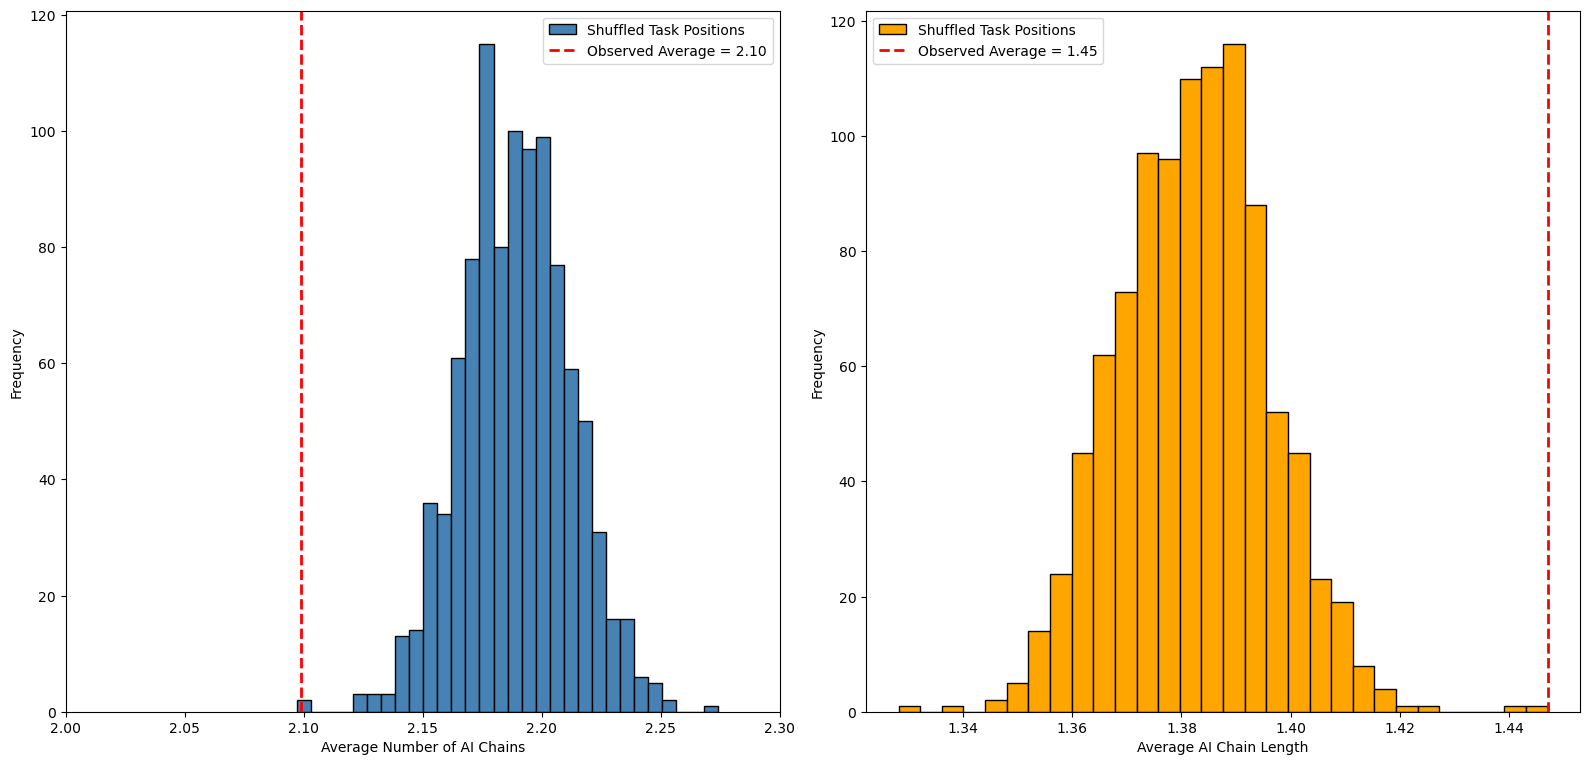

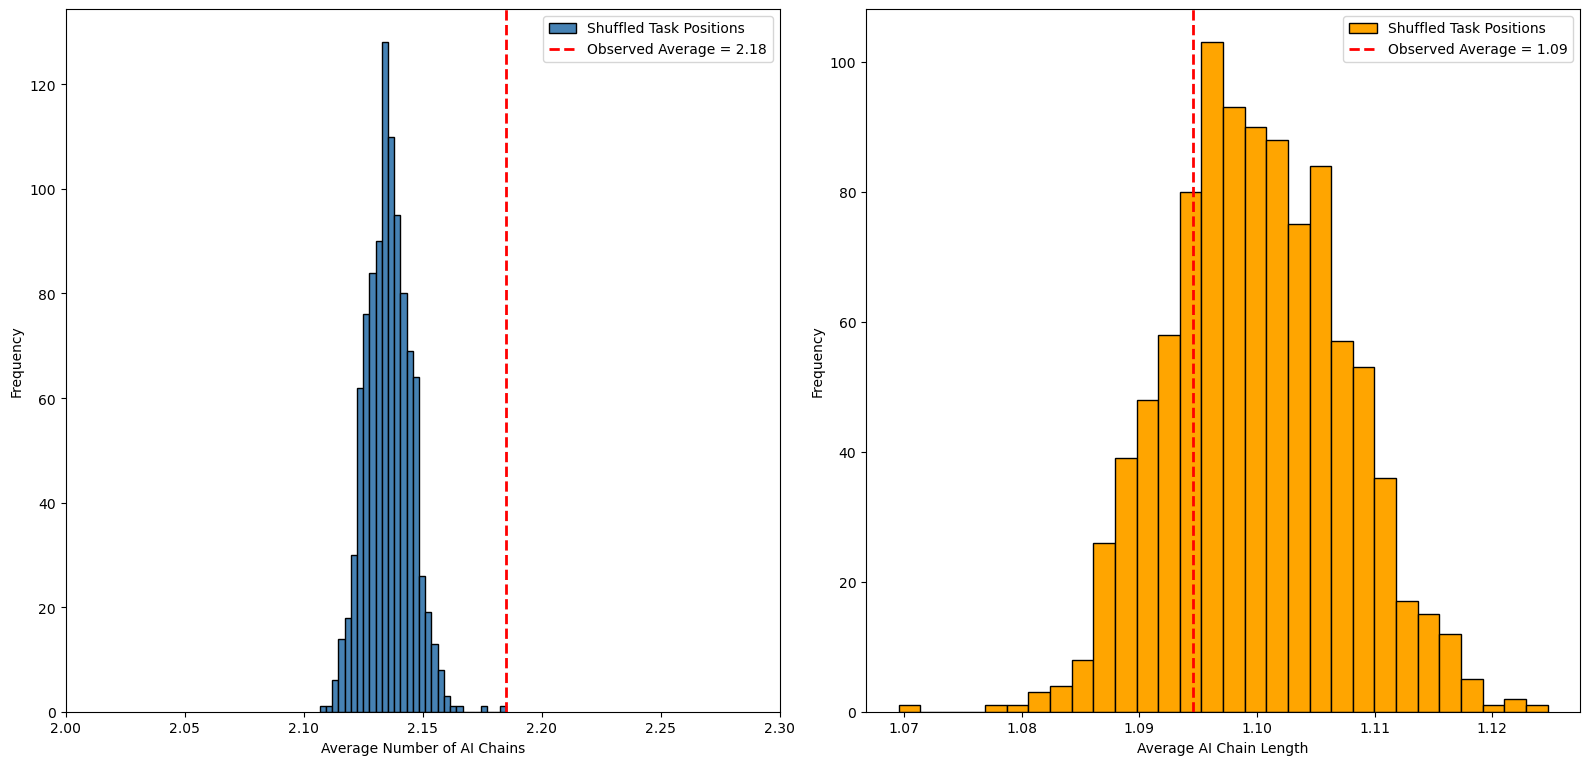

In [42]:
# Plot
plot_titles = ['(#1): Any Contiguous Sequence of AI Tasks', '(#2): Starts with Automation/Augmentation and Ends with first Augmentation after Start']

for def_idx, results_df in enumerate([results_df_def1, results_df_def2]):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # ---- Left plot: Average Number of AI Chains ----
    axes[0].hist(results_df['num_ai_chains'], bins=30, color='steelblue', edgecolor='black', label='Shuffled Task Positions')
    axes[0].axvline(x=results_df.iloc[0]['num_ai_chains'], color='red', linestyle='dashed', linewidth=2,
                    label=f'Observed Average = {results_df.iloc[0]["num_ai_chains"]:.2f}')
    axes[0].set_xlabel('Average Number of AI Chains')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].set_xlim(2, 2.3)

    # ---- Right plot: Average Chain Length ----
    axes[1].hist(results_df['mean_chain_length'], bins=30, color='orange', edgecolor='black', label='Shuffled Task Positions')
    axes[1].axvline(x=results_df.iloc[0]['mean_chain_length'], color='red', linestyle='dashed', linewidth=2,
                    label=f'Observed Average = {results_df.iloc[0]["mean_chain_length"]:.2f}')
    axes[1].set_xlabel('Average AI Chain Length')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    # axes[1].set_xlim(1.25, 1.5)

    # fig.suptitle(f'AI Chain Definition {plot_titles[def_idx]}\n\nTask Position Reshuffled vs. Observed AI Chain Measures (n={n_shuffles})', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f"{output_plot_path}/aiChains_count_length_taskPositionReshuffle_definition{def_idx+1}.png", dpi=300)
    plt.show()

## Reshuffle Task Assignments

In [43]:
# Reshuffle Task Positions within each occupation and recompute AI chain statistics
n_shuffles = 1000

first_output_file = f"{output_data_path}/aiChains_taskAssignmentReshuffle_definition1.csv"
second_output_file = f"{output_data_path}/aiChains_taskAssignmentReshuffle_definition2.csv"

# Run shuffles if output files do not already exist
if not os.path.exists(first_output_file) or not os.path.exists(second_output_file):
    results_d1 = []
    results_d2 = []

    # Original run
    ai_chains_df, chain_lengths, mean_chain_length, num_ai_chains = create_ai_chains_df_def1(merged_data, group_cols)
    results_d1.append({
        'shuffle_index': 0,
        'mean_chain_length': mean_chain_length,
        'num_ai_chains': num_ai_chains
    })

    ai_chains_df, chain_lengths, mean_chain_length, num_ai_chains = create_ai_chains_df_def2(merged_data, group_cols)
    results_d2.append({
        'shuffle_index': 0,
        'mean_chain_length': mean_chain_length,
        'num_ai_chains': num_ai_chains
    })

    # Run shuffles
    for i in range(n_shuffles):
        if i % 50 == 0:
            print(f'Processing shuffle {i} out of {n_shuffles}')

        seed = 42 + i

        # Prepared shuffled dataframe
        reshuffled_merged_data = pd.read_csv(f'{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT/taskReshuffled_preserveCounts/ONET_Eloundou_Anthropic_GPT_iter{i+1}.csv')
        df_shuf = reshuffled_merged_data.copy()

        # Definition 1:
        ai_chains_df_shuf_def1, chain_lengths_shuf_def1, mean_chain_length_shuf_def1, num_ai_chains_shuf_def1 = create_ai_chains_df_def1(df_shuf, group_cols)
        results_d1.append({
            'shuffle_index': i,
            'mean_chain_length': mean_chain_length_shuf_def1,
            'num_ai_chains': num_ai_chains_shuf_def1
        })

        # Definition 2:
        ai_chains_df_shuf_def2, chain_lengths_shuf_def2, mean_chain_length_shuf_def2, num_ai_chains_shuf_def2 = create_ai_chains_df_def2(df_shuf, group_cols)
        results_d2.append({
            'shuffle_index': i,
            'mean_chain_length': mean_chain_length_shuf_def2,
            'num_ai_chains': num_ai_chains_shuf_def2
        })

    # Save results
    results_df_def1 = pd.DataFrame(results_d1)
    results_df_def2 = pd.DataFrame(results_d2)
    results_df_def1.to_csv(first_output_file, index=False)
    results_df_def2.to_csv(second_output_file, index=False)
else:
    # Load results
    results_df_def1 = pd.read_csv(first_output_file)
    results_df_def2 = pd.read_csv(second_output_file)

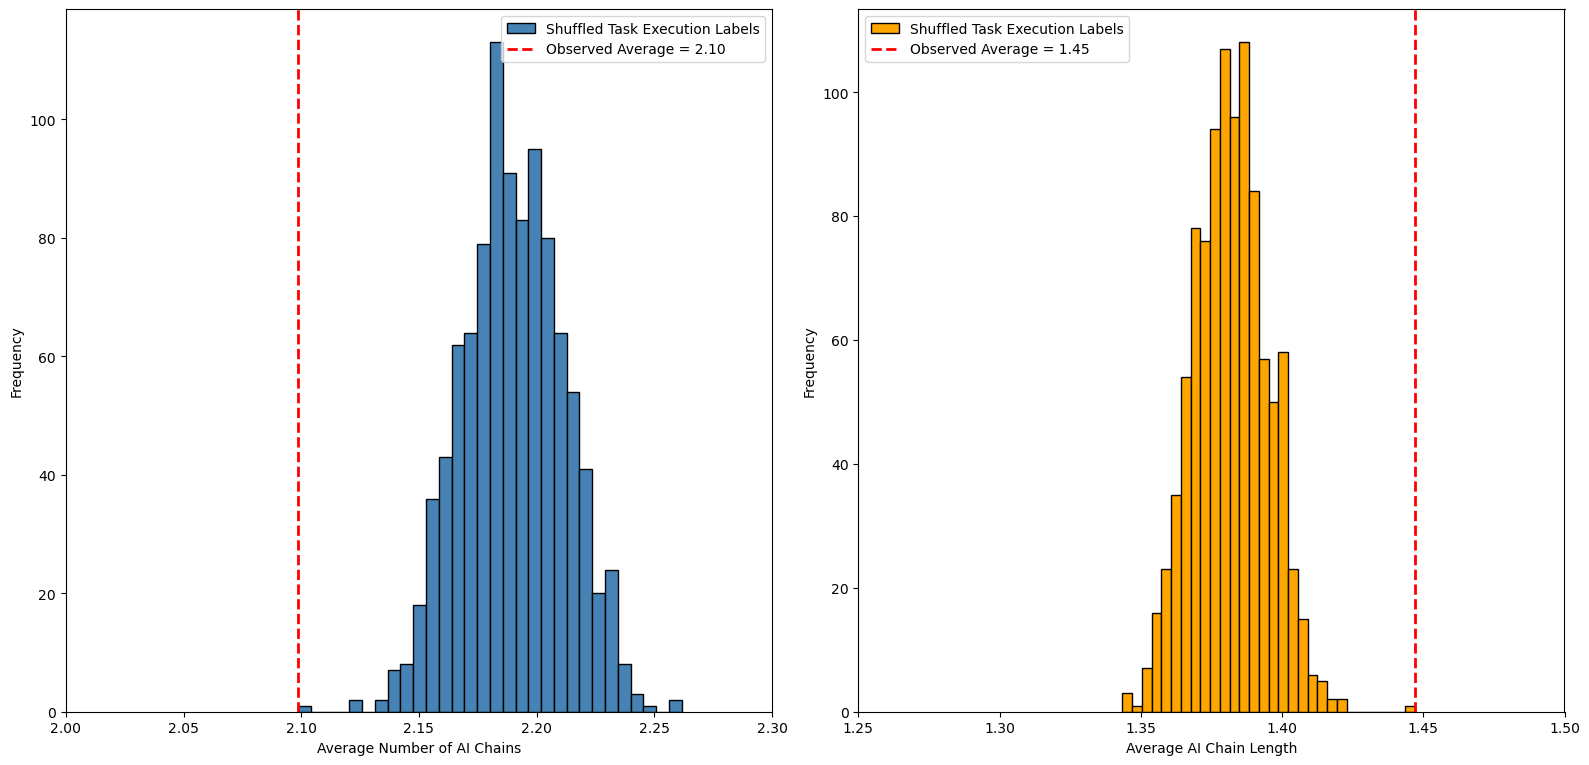

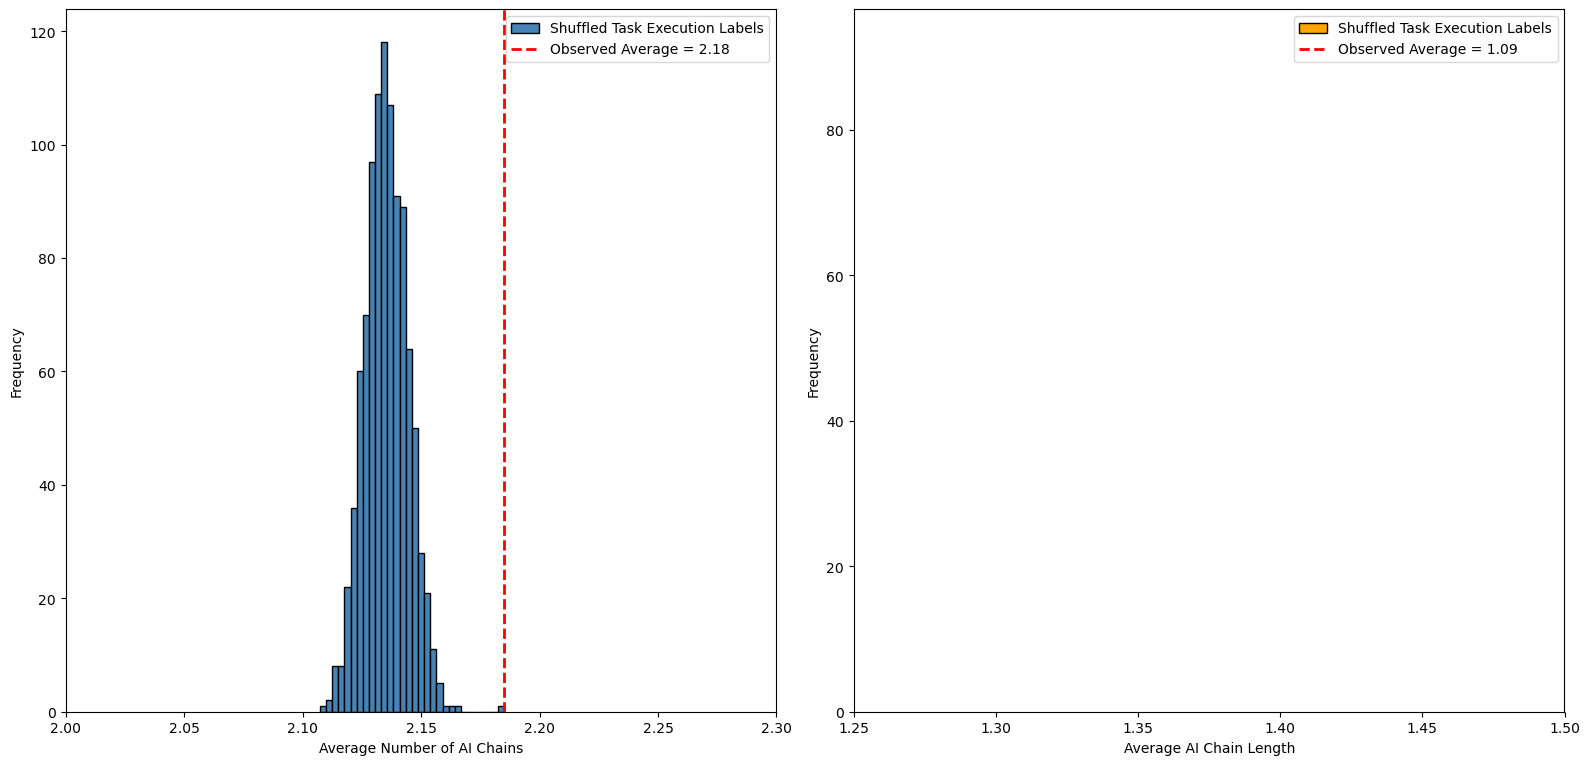

In [44]:
plot_titles = ['(#1): Any Contiguous Sequence of AI Tasks', '(#2): Starts with Automation/Augmentation and Ends with first Augmentation after Start']

for def_idx, results_df in enumerate([results_df_def1, results_df_def2]):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    num_ai_chains = results_df['num_ai_chains'].mean()
    mean_chain_length = results_df['mean_chain_length'].mean()

    # ---- Left plot: Average Number of AI Chains ----
    axes[0].hist(results_df['num_ai_chains'], bins=30, color='steelblue', edgecolor='black', label='Shuffled Task Execution Labels')
    axes[0].axvline(x=results_df.iloc[0]['num_ai_chains'], color='red', linestyle='dashed', linewidth=2,
                    label=f'Observed Average = {results_df.iloc[0]["num_ai_chains"]:.2f}')
    axes[0].set_xlabel('Average Number of AI Chains')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].set_xlim(2, 2.3)

    # ---- Right plot: Average Chain Length ----
    axes[1].hist(results_df['mean_chain_length'], bins=30, color='orange', edgecolor='black', label='Shuffled Task Execution Labels')
    axes[1].axvline(x=results_df.iloc[0]['mean_chain_length'], color='red', linestyle='dashed', linewidth=2,
                    label=f'Observed Average = {results_df.iloc[0]["mean_chain_length"]:.2f}')
    axes[1].set_xlabel('Average AI Chain Length')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].set_xlim(1.25, 1.5)

    # fig.suptitle(f'AI Chain Definition {plot_titles[def_idx]}\n\nTask Assignment Reshuffled vs. Observed AI Chain Measures (n={n_shuffles})', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f"{output_plot_path}/aiChains_count_length_taskAssignmentReshuffle_definition{def_idx+1}.png", dpi=300)
    plt.show()